In [43]:
#!/usr/bin/env python3
"""
Optimization example for detector position in optical system.
"""

import numpy as np
import jax
import jax.numpy as jnp
import optax
from chromatix.elements.sources import GaussianPlaneWave
from chromatix.elements import Propagate, ThinLens
import matplotlib.pyplot as plt 
import chromatix.functional as cf
from chromatix.systems import OpticalSystem

# Set up for reproducible results
jax.config.update("jax_enable_x64", True)  # Enable 64-bit precision
print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")


JAX version: 0.6.2
JAX devices: [CpuDevice(id=0)]


In [44]:
# Define system parameters (same as original notebook)
shape = (512, 512)  # Field grid size
dx = 1e-6  # 1 micron pixel spacing
spectrum = 632.8e-9  # Red laser wavelength (HeNe)
spectral_density = 1.0
waist = 50e-6  # 50 micron beam waist
f = 10e-3  # 10 mm focal length lens
n = 1.0  # Air
power = 1.0
NA = 0.5  # Numerical aperture

print(f"System parameters:")
print(f"  Grid shape: {shape}")
print(f"  Pixel size: {dx*1e6:.1f} μm")
print(f"  Wavelength: {spectrum*1e9:.1f} nm")
print(f"  Beam waist: {waist*1e6:.1f} μm")
print(f"  Focal length: {f*1e3:.1f} mm")
print(f"  Numerical aperture: {NA}")


System parameters:
  Grid shape: (512, 512)
  Pixel size: 1.0 μm
  Wavelength: 632.8 nm
  Beam waist: 50.0 μm
  Focal length: 10.0 mm
  Numerical aperture: 0.5


In [45]:
# Define loss functions (same as original notebook)
def loss_intensity(output_field, input_light):
    """Compute intensity matching loss."""
    return jnp.sum(jnp.abs(output_field.intensity - input_light.intensity)**2)

def loss_circularity(output_field, input_light):
    """Compute circularity loss - how close the beam is to a perfect circle."""
    # Get the intensity field
    intensity = output_field.intensity.squeeze()
    
    # Find the center of mass of the intensity
    y_coords, x_coords = jnp.meshgrid(jnp.arange(intensity.shape[0]), jnp.arange(intensity.shape[1]), indexing='ij')
    total_intensity = jnp.sum(intensity)
    center_y = jnp.sum(y_coords * intensity) / total_intensity
    center_x = jnp.sum(x_coords * intensity) / total_intensity
    
    # Calculate distance from center for each pixel
    distances = jnp.sqrt((y_coords - center_y)**2 + (x_coords - center_x)**2)
    
    # Create a circular mask based on the effective radius (where intensity drops to 1/e^2 of max)
    max_intensity = jnp.max(intensity)
    threshold = max_intensity / (jnp.e**2)
    
    # Use jnp.where to avoid boolean indexing (JAX limitation)
    # Set distances to -inf where intensity is below threshold, then take max
    valid_distances = jnp.where(intensity > threshold, distances, -jnp.inf)
    effective_radius = jnp.max(valid_distances)
    
    # Handle edge case where no pixels are above threshold
    effective_radius = jnp.where(effective_radius == -jnp.inf, 
                                jnp.max(distances), 
                                effective_radius)
    
    # Create ideal circular intensity profile
    ideal_circle = jnp.exp(-2 * (distances / effective_radius)**2)
    ideal_circle = ideal_circle * max_intensity
    
    # Calculate circularity loss as mean squared error from ideal circle
    circularity_loss = jnp.mean((intensity - ideal_circle)**2)
    
    return circularity_loss

def joint_loss(output_field, input_light):
    """Combined loss function."""
    return loss_intensity(output_field, input_light) + loss_circularity(output_field, input_light)

print("Loss functions defined.")


Loss functions defined.


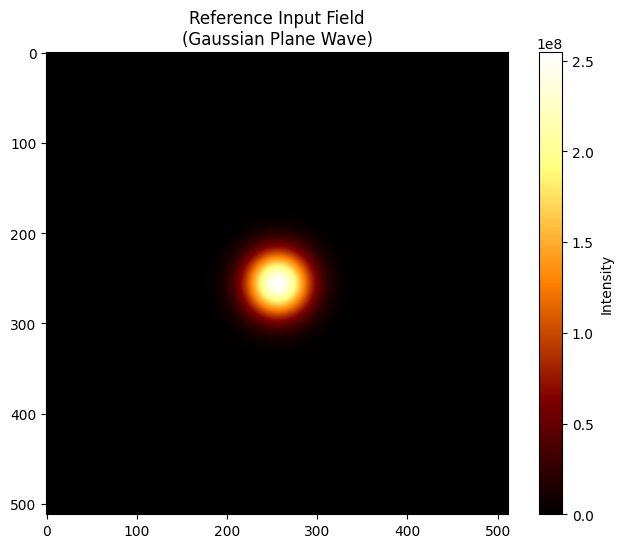

Reference field created with shape: (1, 512, 512, 1, 1)


In [46]:
# Create reference input field
input_light = cf.gaussian_plane_wave(
    shape=shape,
    dx=dx,
    spectrum=spectrum,
    spectral_density=spectral_density,
    power=power,
    waist=waist
)

# Visualize the reference field
plt.figure(figsize=(8, 6))
plt.imshow(input_light.intensity.squeeze(), cmap='afmhot')
plt.title('Reference Input Field\n(Gaussian Plane Wave)')
plt.colorbar(label='Intensity')
plt.axis('on')
plt.show()

print(f"Reference field created with shape: {input_light.intensity.shape}")


In [47]:
# Define the parametric optical system
def create_optical_system(detector_distance):
    """Create optical system with parameterized detector distance."""
    return OpticalSystem(
        elements=[
            GaussianPlaneWave(
                shape=shape,
                dx=dx,
                spectrum=spectrum,
                spectral_density=spectral_density,
                power=power,
                waist=waist
            ),
            Propagate(z=jnp.array(10e-3), n=jnp.array(n)),  # 10mm propagation
            ThinLens(f=jnp.array(f), n=jnp.array(n), NA=jnp.array(NA)),  # First lens
            Propagate(z=jnp.array(20e-3), n=jnp.array(n)),  # 20mm propagation
            ThinLens(f=jnp.array(f), n=jnp.array(n), NA=jnp.array(NA)),  # Second lens
            Propagate(z=detector_distance, n=jnp.array(n))  # Variable detector distance
        ])

# Test system creation
test_system = create_optical_system(jnp.array(5e-3))  # 5mm test distance
key = jax.random.PRNGKey(42)
test_params = test_system.init(key)
test_output = test_system.apply(test_params)
print(f"Test system created successfully. Output field shape: {test_output.intensity.shape}")
print(f"Test field type: {type(test_output)}")

Test system created successfully. Output field shape: (1, 512, 512, 1, 1)
Test field type: <class 'chromatix.field.ScalarField'>


In [48]:
# Define the objective function for optimization
def objective_function(detector_distance):
    """Objective function that takes detector distance and returns loss."""
    # Create optical system with current detector distance
    optical_system = create_optical_system(detector_distance)
    
    # Initialize system
    key = jax.random.PRNGKey(42)  # Fixed seed for reproducibility
    params = optical_system.init(key)
    
    # Run the optical system
    output_field = optical_system.apply(params)
    
    # Compute loss
    loss = joint_loss(output_field, input_light)
    
    return loss

# JIT compile the objective function for speed
objective_function_jit = jax.jit(objective_function)

# Test the objective function
test_distance = jnp.array(5e-3)
test_loss = objective_function_jit(test_distance)
print(f"Test objective function call:")
print(f"  Distance: {test_distance*1e3:.1f} mm")
print(f"  Loss: {test_loss:.6f}")

Test objective function call:
  Distance: 5.0 mm
  Loss: 1345139312537949696.000000


In [49]:
# Compute gradient of objective function
grad_objective = jax.grad(objective_function_jit)

# Test gradient computation
test_grad = grad_objective(test_distance)
print(f"Test gradient computation:")
print(f"  Distance: {test_distance*1e3:.1f} mm")
print(f"  Gradient: {test_grad:.2e}")
print(f"  Gradient direction: {'minimize' if test_grad > 0 else 'maximize'} distance")

Test gradient computation:
  Distance: 5.0 mm
  Gradient: -9.67e+20
  Gradient direction: maximize distance


In [50]:
# Set up optimization
learning_rate = 1e-4  # Start with small learning rate for stability
num_steps = 600

# Initialize optimizer (Adam is generally robust)
optimizer = optax.adam(learning_rate=learning_rate)

# Initial guess for detector distance (middle of reasonable range)
initial_distance = jnp.array(20e-3)  # 10mm
detector_distance = initial_distance

# Initialize optimizer state
opt_state = optimizer.init(detector_distance)

# Storage for optimization history
distances_history = []
losses_history = []
grad_norms_history = []

print(f"Optimization setup:")
print(f"  Learning rate: {learning_rate:.0e}")
print(f"  Number of steps: {num_steps}")
print(f"  Initial distance: {initial_distance*1e3:.1f} mm")
print(f"  Optimizer: Adam")

Optimization setup:
  Learning rate: 1e-04
  Number of steps: 600
  Initial distance: 20.0 mm
  Optimizer: Adam


In [51]:
# Run optimization
print("Starting optimization...")
print("Step | Distance (mm) | Loss      | Grad Norm | Improvement")
print("-" * 60)

for step in range(num_steps):
    # Compute loss and gradient
    loss_value = objective_function_jit(detector_distance)
    grad_value = grad_objective(detector_distance)
    
    # Store history
    distances_history.append(float(detector_distance))
    losses_history.append(float(loss_value))
    grad_norms_history.append(float(jnp.abs(grad_value)))
    
    # Update parameters
    updates, opt_state = optimizer.update(grad_value, opt_state)
    detector_distance = optax.apply_updates(detector_distance, updates)
    
    # Clamp detector distance to reasonable bounds (0.1mm to 50mm)
    detector_distance = jnp.clip(detector_distance, 0.1e-3, 50e-3)
    
    # Print progress every 20 steps
    if step % 20 == 0 or step == num_steps - 1:
        improvement = ""
        if step > 0:
            loss_change = losses_history[-1] - losses_history[-2]
            improvement = f"{loss_change:+.2e}"
        
        print(f"{step:4d} | {detector_distance*1e3:9.3f} | {loss_value:.6f} | {abs(grad_value):.2e} | {improvement}")

final_distance = detector_distance
final_loss = losses_history[-1]

print(f"\nOptimization completed!")
print(f"Initial distance: {initial_distance*1e3:.3f} mm")
print(f"Final distance: {final_distance*1e3:.3f} mm")
print(f"Initial loss: {losses_history[0]:.6f}")
print(f"Final loss: {final_loss:.6f}")
print(f"Loss reduction: {(losses_history[0] - final_loss)/losses_history[0]*100:.2f}%")

Starting optimization...
Step | Distance (mm) | Loss      | Grad Norm | Improvement
------------------------------------------------------------
   0 |    19.900 | 12288862825999079424.000000 | 3.36e+21 | 
  20 |    17.941 | 6480884397089681408.000000 | 2.49e+21 | -2.38e+17
  40 |    16.220 | 2949608967860950528.000000 | 1.58e+21 | -1.25e+17
  60 |    14.909 | 1295569468192202496.000000 | 9.23e+20 | -5.27e+16
  80 |    14.002 | 619054691695141760.000000 | 5.53e+20 | -2.14e+16
 100 |    13.382 | 334638274655153792.000000 | 3.58e+20 | -9.55e+15
 120 |    12.941 | 200086739258235136.000000 | 2.46e+20 | -4.78e+15
 140 |    12.613 | 130264640629482528.000000 | 1.75e+20 | -2.56e+15
 160 |    12.362 | 91719583762845088.000000 | 1.31e+20 | -1.48e+15
 180 |    12.161 | 69355649123772224.000000 | 1.02e+20 | -9.42e+14
 200 |    11.993 | 53400384112475040.000000 | 8.75e+19 | -6.97e+14
 220 |    11.843 | 41082208160279616.000000 | 7.58e+19 | -5.48e+14
 240 |    11.708 | 31556353309336512.000000 | 6

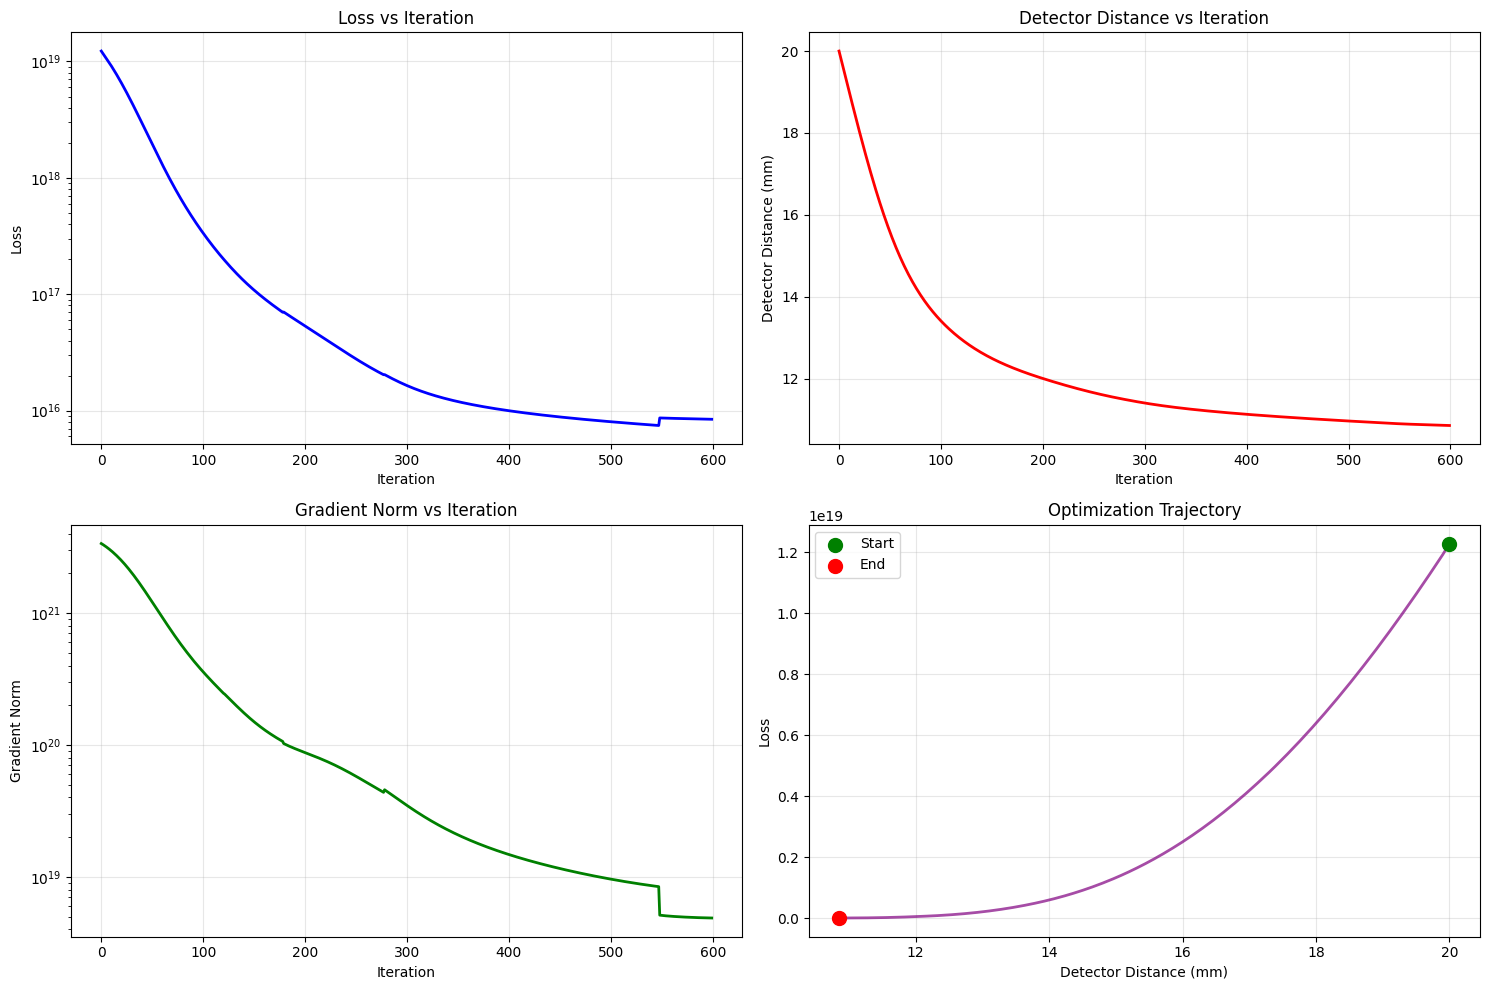

In [52]:
# Plot optimization progress
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Loss over iterations
ax1.plot(losses_history, 'b-', linewidth=2)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax1.set_title('Loss vs Iteration')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Detector distance over iterations
distances_mm = [d*1e3 for d in distances_history]
ax2.plot(distances_mm, 'r-', linewidth=2)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Detector Distance (mm)')
ax2.set_title('Detector Distance vs Iteration')
ax2.grid(True, alpha=0.3)

# Plot 3: Gradient norm over iterations
ax3.plot(grad_norms_history, 'g-', linewidth=2)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Gradient Norm')
ax3.set_title('Gradient Norm vs Iteration')
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# Plot 4: Loss vs detector distance (trajectory)
ax4.plot(distances_mm, losses_history, 'purple', linewidth=2, alpha=0.7)
ax4.scatter(distances_mm[0], losses_history[0], color='green', s=100, label='Start', zorder=5)
ax4.scatter(distances_mm[-1], losses_history[-1], color='red', s=100, label='End', zorder=5)
ax4.set_xlabel('Detector Distance (mm)')
ax4.set_ylabel('Loss')
ax4.set_title('Optimization Trajectory')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

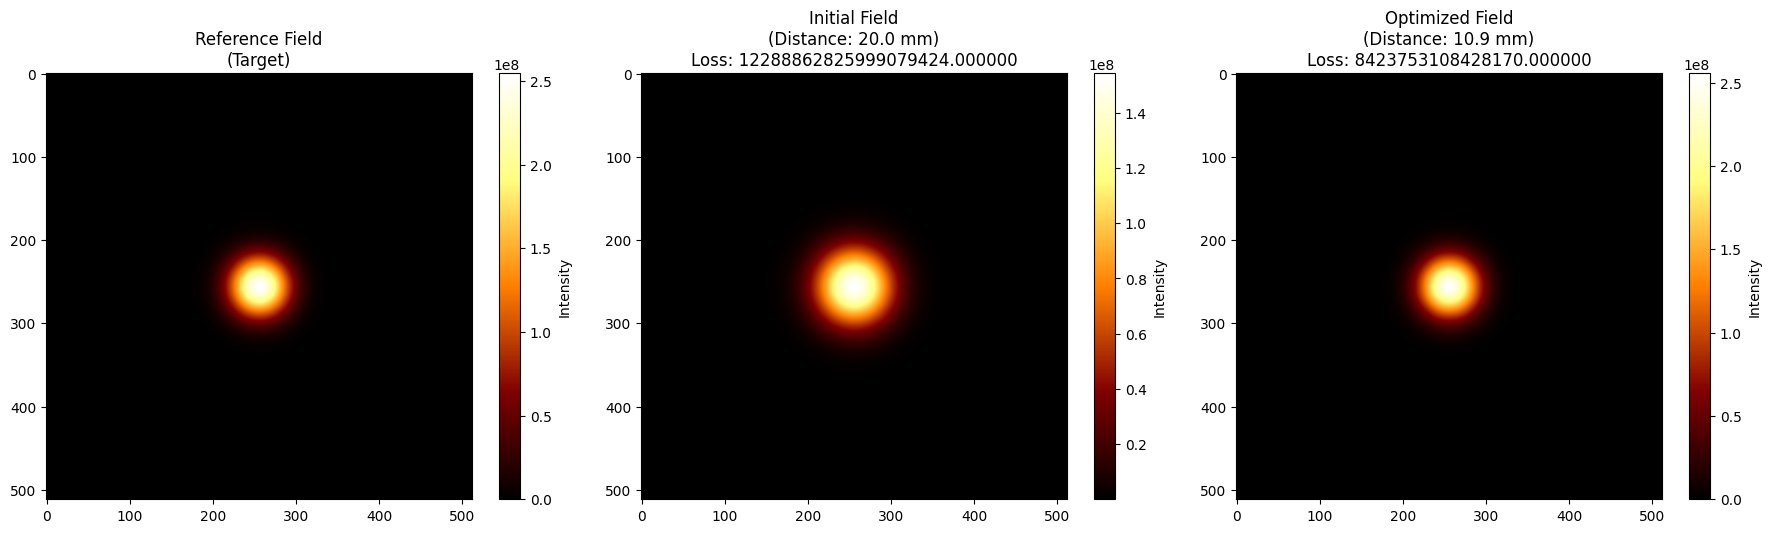


Field comparison:
Initial loss components:
  Intensity loss: 12288862825546211328.000000
  Circularity loss: 452864911.955692
Final loss components:
  Intensity loss: 8419843467523313.000000
  Circularity loss: 47867327394.221001


In [53]:
# Compare initial and final field distributions
# Initial system
initial_system = create_optical_system(initial_distance)
key = jax.random.PRNGKey(42)
initial_params = initial_system.init(key)
initial_output = initial_system.apply(initial_params)

# Final optimized system
final_system = create_optical_system(final_distance)
final_params = final_system.init(key)
final_output = final_system.apply(final_params)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Reference field
im1 = axes[0].imshow(input_light.intensity.squeeze(), cmap='afmhot')
axes[0].set_title(f'Reference Field\n(Target)')
axes[0].axis('on')
plt.colorbar(im1, ax=axes[0], label='Intensity')

# Initial field
im2 = axes[1].imshow(initial_output.intensity.squeeze(), cmap='afmhot')
axes[1].set_title(f'Initial Field\n(Distance: {initial_distance*1e3:.1f} mm)\nLoss: {losses_history[0]:.6f}')
axes[1].axis('on')
plt.colorbar(im2, ax=axes[1], label='Intensity')

# Final optimized field
im3 = axes[2].imshow(final_output.intensity.squeeze(), cmap='afmhot')
axes[2].set_title(f'Optimized Field\n(Distance: {final_distance*1e3:.1f} mm)\nLoss: {final_loss:.6f}')
axes[2].axis('on')
plt.colorbar(im3, ax=axes[2], label='Intensity')

plt.tight_layout()
plt.show()

print(f"\nField comparison:")
print(f"Initial loss components:")
print(f"  Intensity loss: {loss_intensity(initial_output, input_light):.6f}")
print(f"  Circularity loss: {loss_circularity(initial_output, input_light):.6f}")
print(f"Final loss components:")
print(f"  Intensity loss: {loss_intensity(final_output, input_light):.6f}")
print(f"  Circularity loss: {loss_circularity(final_output, input_light):.6f}")
